In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [3]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v0")
max_torque = 15.
env.action_space.high, env.action_space.low = max_torque, -max_torque
# site-packages/gym/envs/classic_control/pendulum.py

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [4]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [5]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent







Training for 2000 steps ...
Interval 1 (0 steps performed)
 1998/10000 [====>.........................] - ETA: 2:30 - reward: -5.4877done, took 37.553 seconds


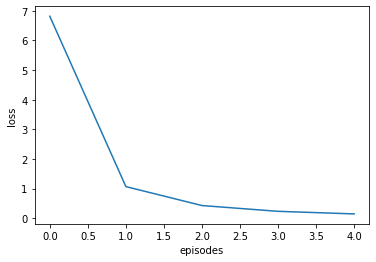

In [6]:
#event-base learning
l = 0.02
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=2000, visualize=1, verbose=1, nb_max_episode_steps=200, loss_graph=1)

In [23]:
a.test(env, lam=l, visualize=False, nb_max_episode_steps=200, graph=False)

Testing for 1 episodes ...
Episode 1: reward: -1120.736, steps: 200


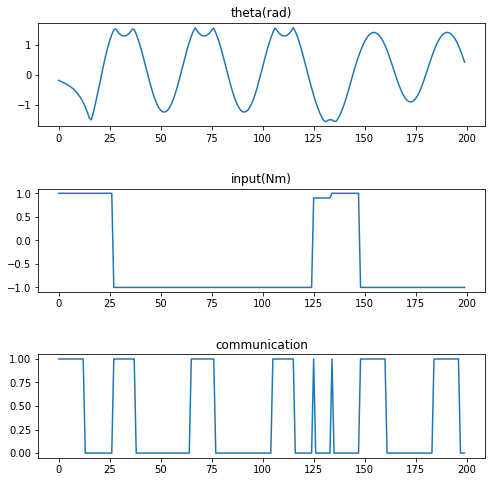

In [24]:
titles = ['theta(rad)', 'input(Nm)', 'communication'] 
history = a.data_log[0]
x_axis = range(200)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(3):
    data = history[:,i]
    plt.subplot(3,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [30]:
print(np.unique(history[:,1]))

[-1.         -0.99999982 -0.99999976 -0.99999928 -0.99999923 -0.99999905
 -0.9999972  -0.99999523 -0.99999517 -0.99999475 -0.99999368 -0.99999291
 -0.99998879 -0.99998873 -0.9999879  -0.99998772 -0.9999845  -0.99998134
 -0.99998128 -0.99997818 -0.99997681 -0.99997145 -0.99996674 -0.99996066
 -0.99995869 -0.99995399 -0.99993342 -0.99990267 -0.99988174 -0.9997648
 -0.9997384  -0.99954098 -0.99942464 -0.99927449 -0.99920809 -0.99906749
 -0.99905998  0.90039897  0.99996454  0.99997759  0.99998629  0.99999225
  0.99999601  0.9999975   0.99999821  0.99999899  0.99999958  0.99999982
  1.        ]


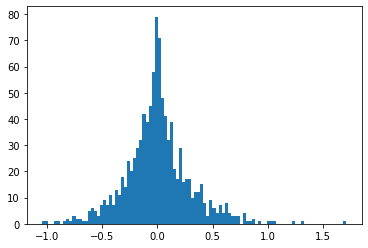

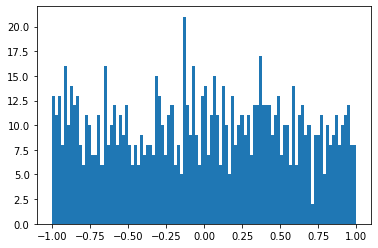

In [11]:
import numpy as np
import matplotlib.pyplot as plt

log = np.zeros((1000,2))
for _ in range(1000):
    high = np.array([np.random.randn() / 2., 1])
    log[_] = np.random.uniform(low=-high, high=high)
plt.hist(log[:,0], bins=100)
plt.show()

plt.hist(log[:,1], bins=100)
plt.show()

In [6]:
for i in range(100):
    print(np.random.randn()/5.)

0.2009269312370538
-0.11333157343002069
0.46042171962808337
0.03722485632983456
-0.3583126722967062
-0.12080824374963355
-0.021470414861225584
0.11804343955116489
0.27723577358351237
0.260064958597283
-0.48501917575689635
-0.16003197494479143
0.3771203253856737
-0.029732311476375804
-0.055318410536205884
0.010965011045892235
0.0909753754541155
-0.13364758958785092
-0.08542529225900769
-0.0004327737821703716
0.1803733297933365
-0.1979137775405988
0.12084810361988552
0.16257364433266183
0.27230349168107304
-0.21070548876327458
0.035549066165088884
-0.12613444342682661
0.0949675024230181
-0.14899054934942552
0.058650572205909725
0.09038571187200105
-0.06886654186872362
-0.07790439166790936
-0.020942517237768035
0.3492293714365616
-0.0035538299496765515
-0.3100773313510294
0.011940312892501744
-0.07308044824235894
0.4258290956711644
0.21597361139818166
-0.014908791420182307
0.035701273868645626
-0.13293813134483673
0.02009988602338087
-0.39764335861555206
-0.21913942006913661
0.10478837166